<a href="https://colab.research.google.com/github/SocialDragonsNeuromatch/NeuromatchProject/blob/main/notebooks/covariance_hcp_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>   

# Load HCP parcellated task data

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nilearn import plotting, datasets

In [2]:
# @title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [4]:
# @title Download the task data

import os, requests, tarfile

fname = "hcp_task.tgz"
url = "https://osf.io/s4h8j/download/"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      print(f"Downloading {fname}...")
      with open(fname, "wb") as fid:
        fid.write(r.content)
      print(f"Download {fname} completed!")
      

In [5]:
# @title Download the rest data

import os, requests, tarfile

fname = "hcp_rest.tgz"
url = "https://osf.io/g759t/download/"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      print(f"Downloading {fname}...")
      with open(fname, "wb") as fid:
        fid.write(r.content)
      print(f"Download {fname} completed!")
      

In [6]:
# @title Extract the task data in `HCP_DIR`
fname_ex = "hcp_task"
path_name = os.path.join(HCP_DIR, fname_ex)
if not os.path.exists(path_name):
  print(f"Extracting {fname_ex}.tgz...")
  with tarfile.open(f"{fname_ex}.tgz") as fzip:
    fzip.extractall(HCP_DIR)
else:
  print(f"File {fname_ex}.tgz has already been extracted.")

File hcp_task.tgz has already been extracted.


In [7]:
# @title Extract the rest data in `HCP_DIR`
fname_ex = "hcp_rest"
path_name = os.path.join(HCP_DIR, fname_ex)
if not os.path.exists(path_name):
  print(f"Extracting {fname_ex}.tgz...")
  with tarfile.open(f"{fname_ex}.tgz") as fzip:
    fzip.extractall(HCP_DIR)
else:
  print(f"File {fname_ex}.tgz has already been extracted.")

File hcp_rest.tgz has already been extracted.


## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [8]:
regions = np.load(os.path.join(HCP_DIR, "hcp_task", "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2))

print(region_info.keys())

dict_keys(['name', 'network', 'hemi'])


In [9]:
region_name_list=region_info['name']
region_network_list=list(region_info['network'].reshape(len(region_name_list),))
region_name_array=np.array(region_name_list)
region_network_array=np.array(region_network_list)

region_number_array=np.array(range(len(region_name_list)))
default_number_array=region_number_array[region_network_array == 'Default']
default_name_array=region_name_array[region_network_array == 'Default']
print(default_number_array)
print(default_name_array)

[ 11  24  25  27  73  74  78  80 122 124 127 128 138 171 191 205 254 258
 302 304 308 318 351]
['R_55b' 'R_PSL' 'R_SFL' 'R_STV' 'R_44' 'R_45' 'R_IFJa' 'R_IFSp' 'R_STGa'
 'R_A5' 'R_STSda' 'R_STSdp' 'R_TPOJ1' 'R_TGv' 'L_55b' 'L_SFL' 'L_45'
 'L_IFJa' 'L_STGa' 'L_A5' 'L_STSdp' 'L_TPOJ1' 'L_TGv']


In [10]:
len(region_name_list)

360

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task. 

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [11]:
def load_single_timeseries(subject, experiment, run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str): Name of experiment
    run (int): 0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run = EXPERIMENTS[experiment]['runs'][run]
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts



def load_evs(subject, experiment, run, dir):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment
    run (int) : 0-based run index, across all tasks

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_' + experiment + '_' + ['RL', 'LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           str(task_key), f"{cond}.txt")

    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list


def load_rest_timeseries(subject, run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str): Name of experiment
    run (int): 0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run = run
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

# Example run

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run

In [15]:
my_exp = 'SOCIAL'
social_all_ts = []
for my_subj in range(N_SUBJECTS):
  two_runs_ts = []
  for my_run in range(N_RUNS):
    data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,dir=os.path.join(HCP_DIR, "hcp_task"), remove_mean=True)
    evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run, dir=os.path.join(HCP_DIR, "hcp_task"))
    two_cons_ts = []
    for idx in range(2):
      label = EXPERIMENTS[my_exp]['cond'][idx]
      sub_evs = evs[idx]
      for j in range(len(sub_evs)):
        if j == 0:
          con_ts = data[:,sub_evs[j]]
        else:
          con_ts = np.concatenate((con_ts,data[:,sub_evs[j]]),axis=-1)
      two_cons_ts.append(con_ts)
    two_runs_ts.append(two_cons_ts)
  social_all_ts.append(two_runs_ts)

In [16]:
my_exp = 'LANGUAGE'
lan_all_ts = []
for my_subj in range(N_SUBJECTS):
  two_runs_ts = []
  for my_run in range(N_RUNS):
    data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,dir=os.path.join(HCP_DIR, "hcp_task"), remove_mean=True)
    evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run, dir=os.path.join(HCP_DIR, "hcp_task"))
    two_cons_ts = []
    for idx in range(2):
      label = EXPERIMENTS[my_exp]['cond'][idx]
      sub_evs = evs[idx]
      for j in range(len(sub_evs)):
        if j == 0:
          con_ts = data[:,sub_evs[j]]
        else:
          con_ts = np.concatenate((con_ts,data[:,sub_evs[j][sub_evs[j]<len(data[0])]]),axis=-1)
      two_cons_ts.append(con_ts)
    two_runs_ts.append(two_cons_ts)
  lan_all_ts.append(two_runs_ts)


In [17]:
N_SUBJECTS

339

In [18]:
try:
    from sklearn.covariance import GraphicalLassoCV
except ImportError:
    # for Scitkit-Learn < v0.20.0
    from sklearn.covariance import GraphLassoCV as GraphicalLassoCV

def get_covariance_matrix(time_series):
    estimator = GraphicalLassoCV()
    estimator.fit(time_series.T)
    return estimator.covariance_

import warnings
warnings.filterwarnings('ignore')

In [22]:
# @title Download `atlas.npz`

import os, requests, tarfile

fname = "atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      print(f"Downloading {fname}...")
      with open(fname, "wb") as fid:
        fid.write(r.content)
      print(f"Download {fname} completed!")

In [24]:
# This uses the nilearn package

with np.load(fname) as dobj:
  atlas = dict(**dobj)

coords = atlas['coords']

In [25]:
len(coords)

360

In [26]:
coords[0]

array([ 13.88705062, -79.36989109,   2.95539586])

In [19]:
cov_mental = []
cov_random = []
cov_math = []
cov_story = []

for my_subj in range(N_SUBJECTS):

    mental_ts = np.concatenate((social_all_ts[my_subj][0][0],social_all_ts[my_subj][1][0]),axis=-1)
    random_ts = np.concatenate((social_all_ts[my_subj][0][1],social_all_ts[my_subj][1][1]),axis=-1)
    math_ts = np.concatenate((lan_all_ts[my_subj][0][0],lan_all_ts[my_subj][1][0]),axis=-1)
    story_ts = np.concatenate((lan_all_ts[my_subj][0][1],lan_all_ts[my_subj][1][1]),axis=-1)
    
    break

    cov_mental.append(get_covariance_matrix(mental_ts))
    cov_random.append(get_covariance_matrix(random_ts))
    cov_math.append(get_covariance_matrix(math_ts))
    cov_story.append(get_covariance_matrix(story_ts))

    if my_subj == 2:
        break

In [20]:
mental_ts.shape

(360, 160)

In [21]:
from sklearn.covariance import GraphicalLassoCV
from sklearn.covariance import EmpiricalCovariance
from sklearn.covariance import ShrunkCovariance
from sklearn.covariance import MinCovDet

estimator_glc = GraphicalLassoCV()
estimator_glc.fit(mental_ts.T)

estimator_ec = EmpiricalCovariance()
estimator_ec.fit(mental_ts.T)

estimator_sc = ShrunkCovariance()
estimator_sc.fit(mental_ts.T)

estimator_mcd = MinCovDet()
estimator_mcd.fit(mental_ts.T)

MinCovDet()

In [33]:
len(region_name_list)

360

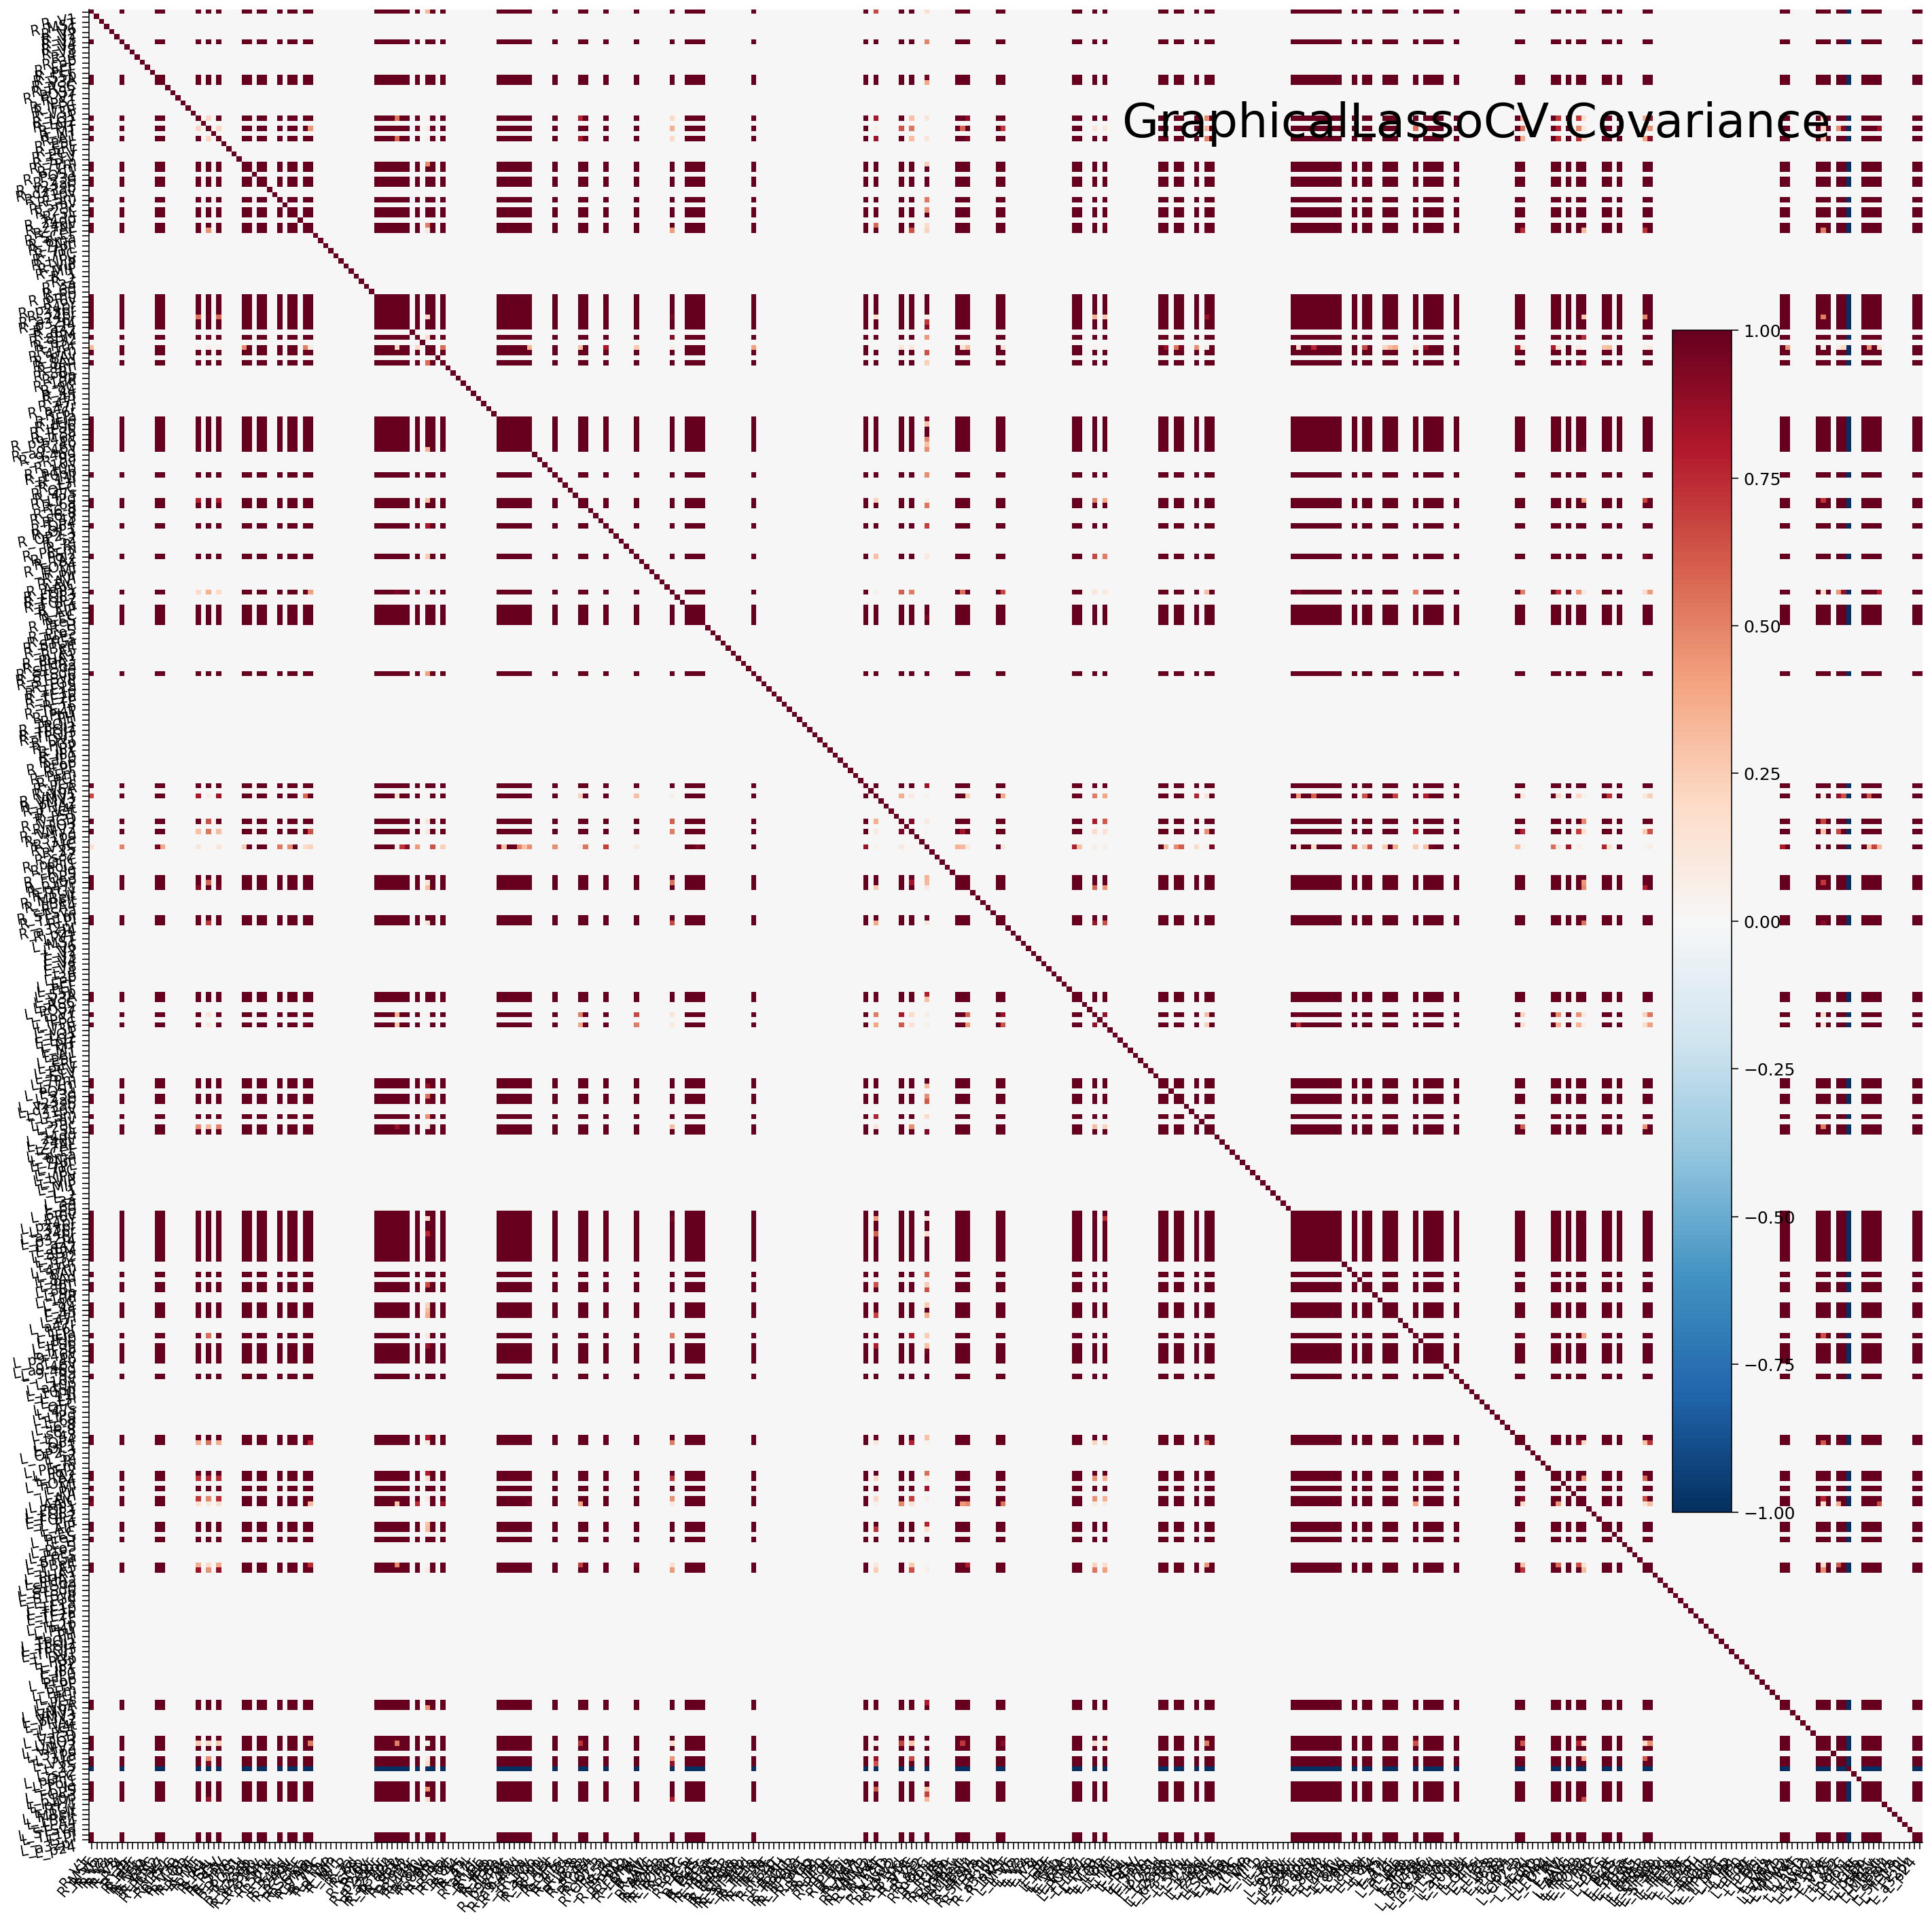

In [33]:
# The covariance can be found at estimator.covariance_
plotting.plot_matrix(estimator_glc.covariance_, labels=region_name_list,
                     figure=(20, 20), vmax=1, vmin=-1,
                     title='GraphicalLassoCV Covariance')

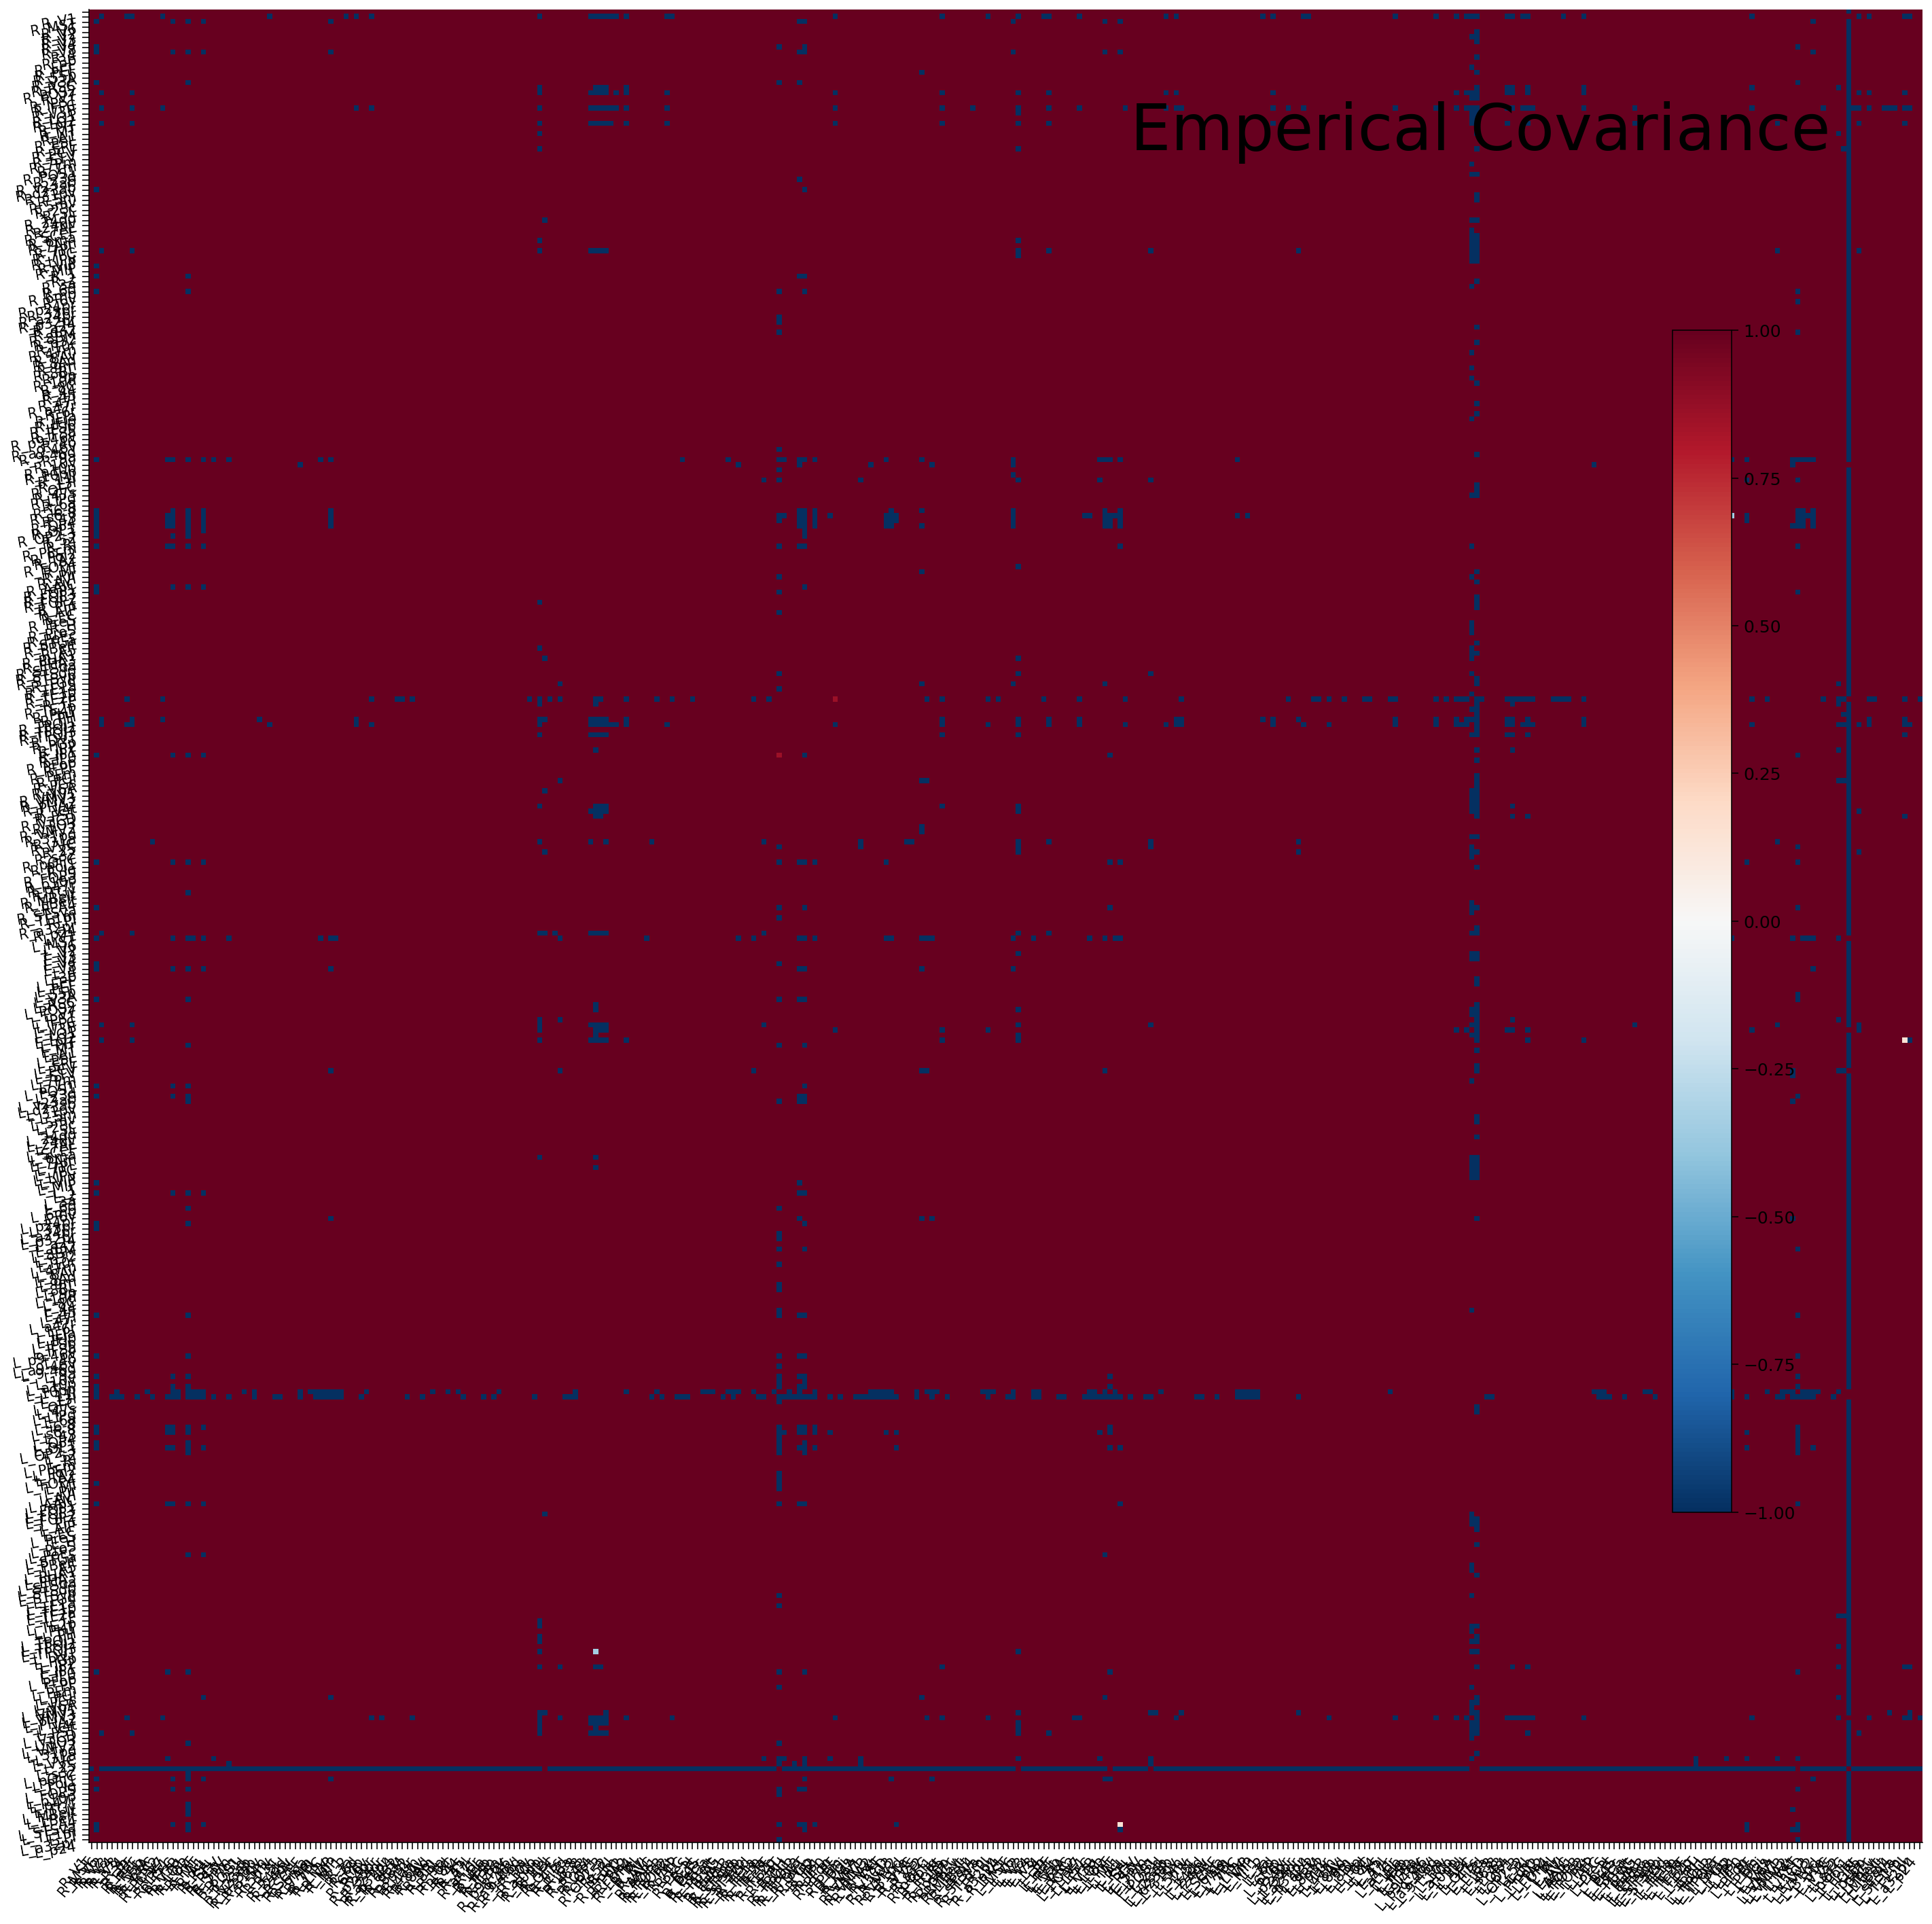

In [34]:
# The covariance can be found at estimator.covariance_
plotting.plot_matrix(estimator_ec.covariance_, labels=region_name_list,
                     figure=(20, 20), vmax=1, vmin=-1,
                     title='Emperical Covariance')

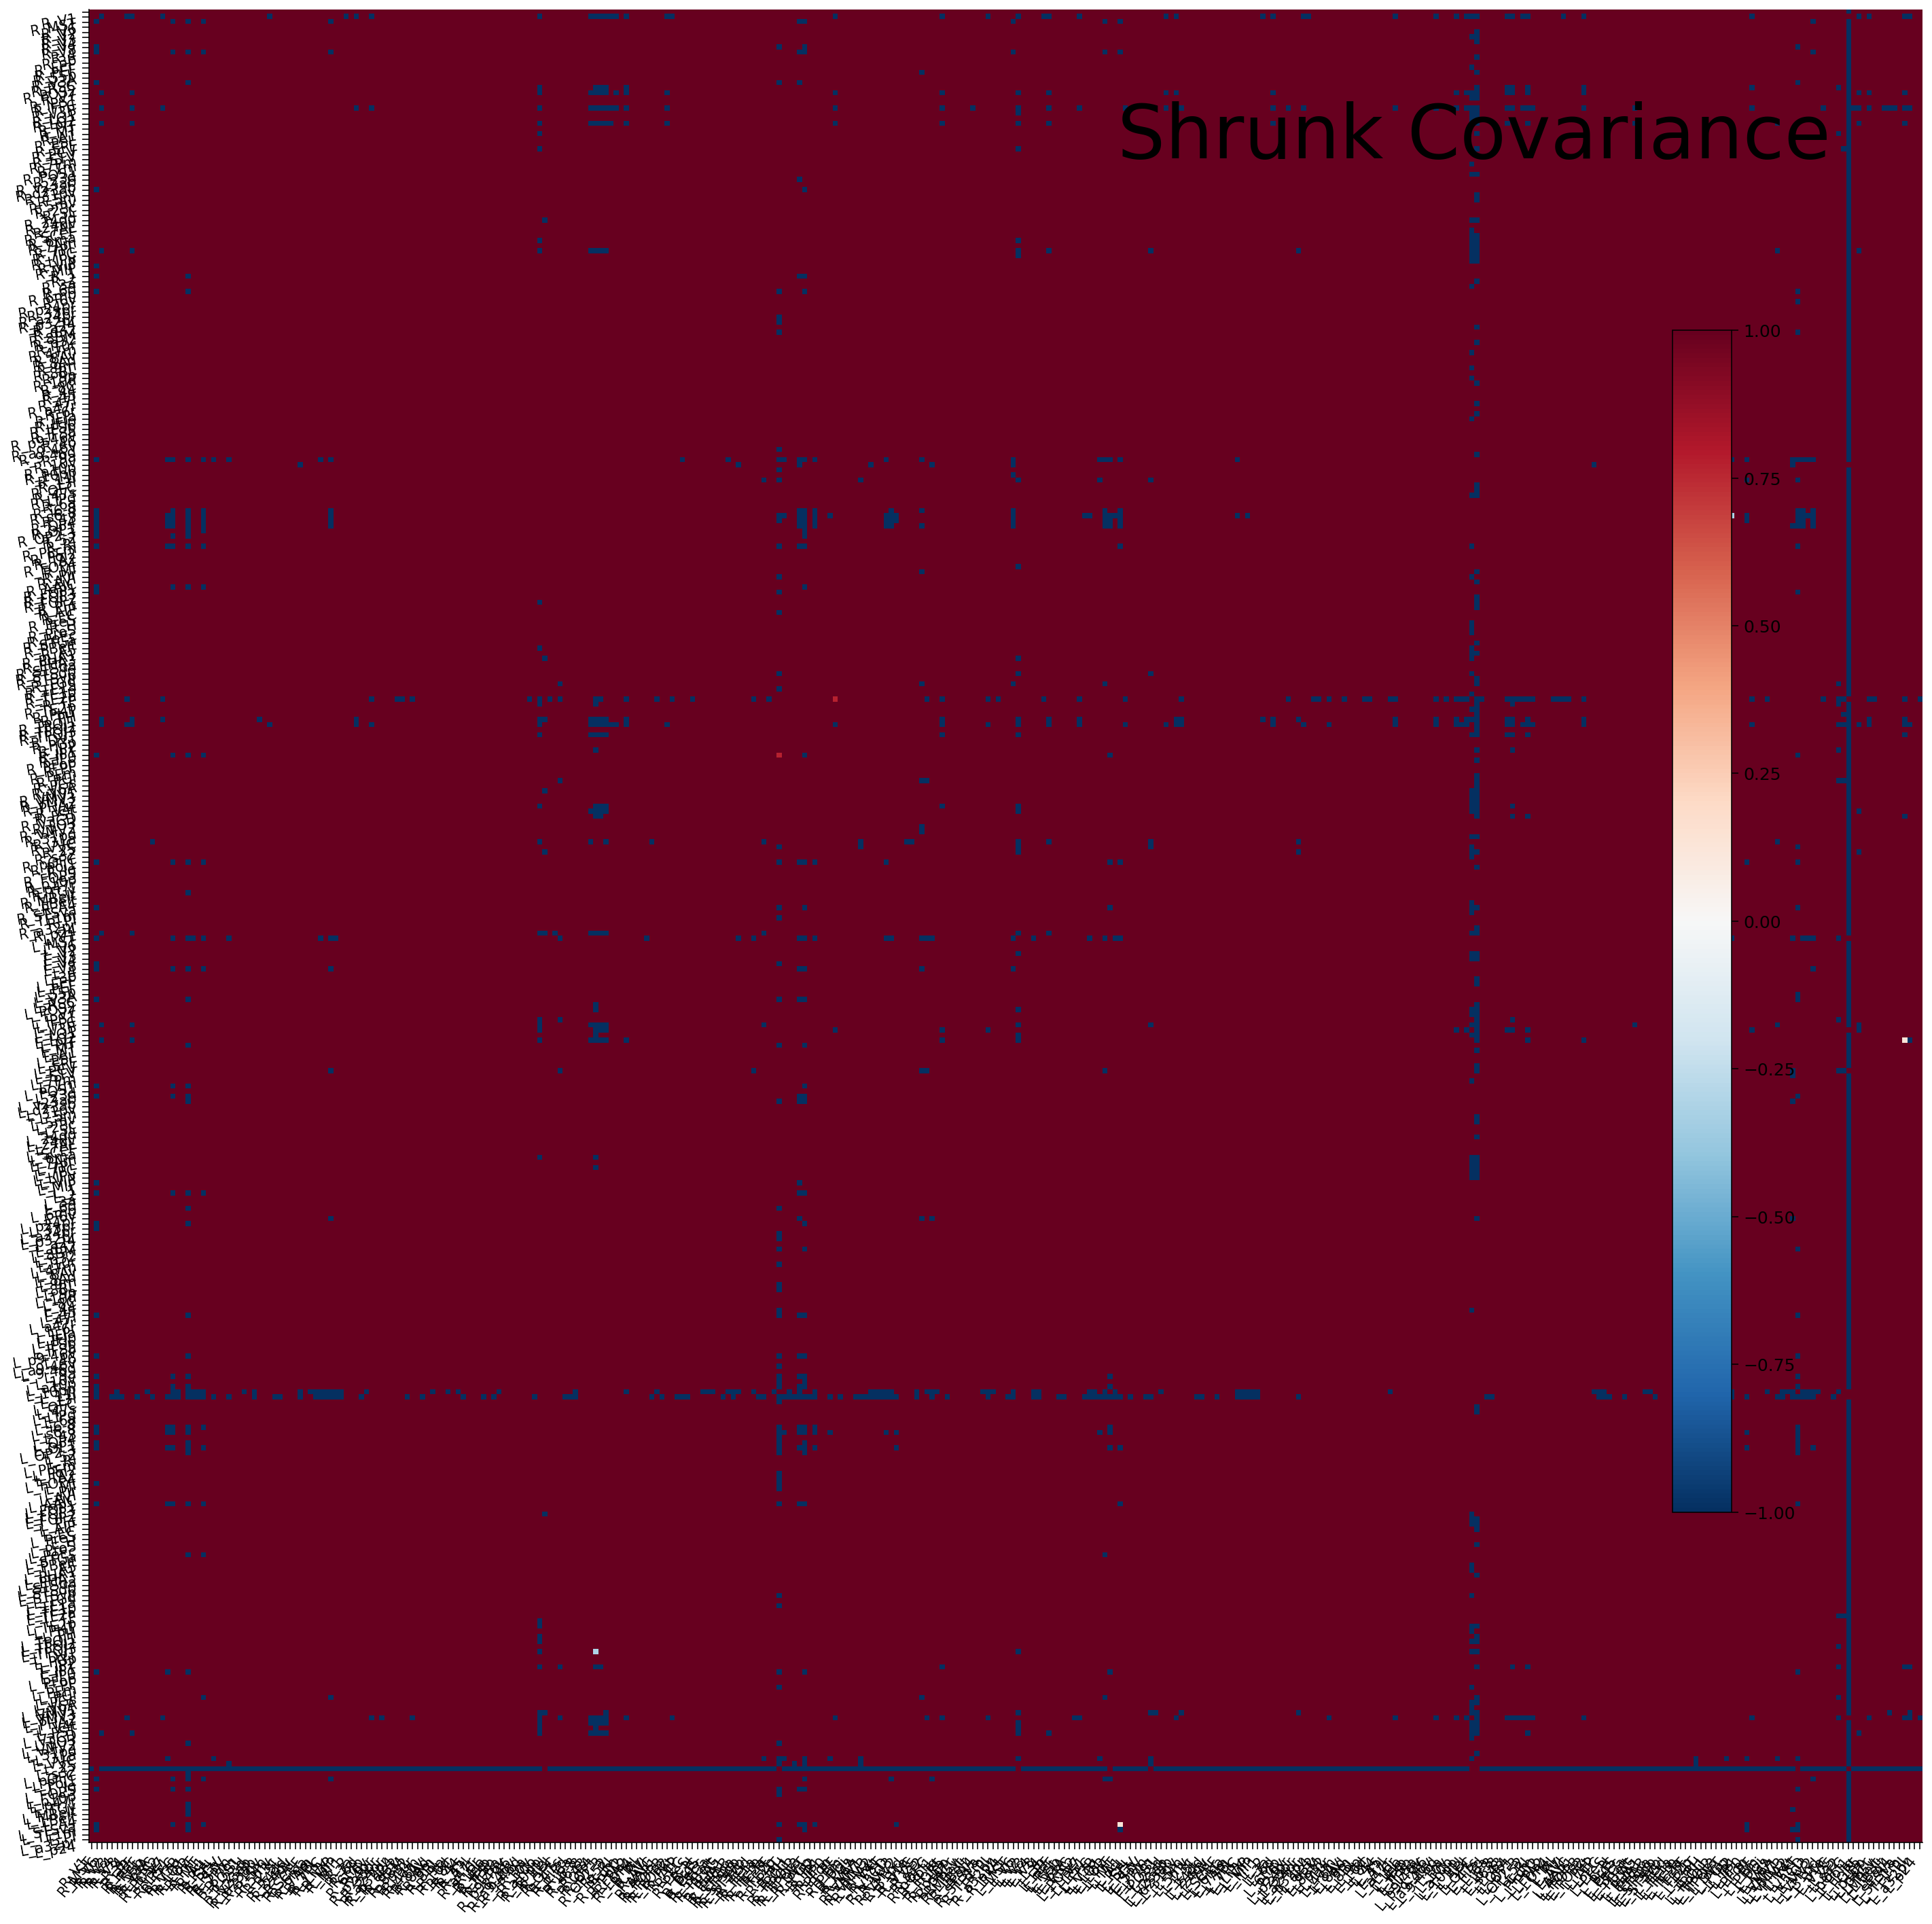

In [35]:
# The covariance can be found at estimator.covariance_
plotting.plot_matrix(estimator_sc.covariance_, labels=region_name_list,
                     figure=(20, 20), vmax=1, vmin=-1,
                     title='Shrunk Covariance')

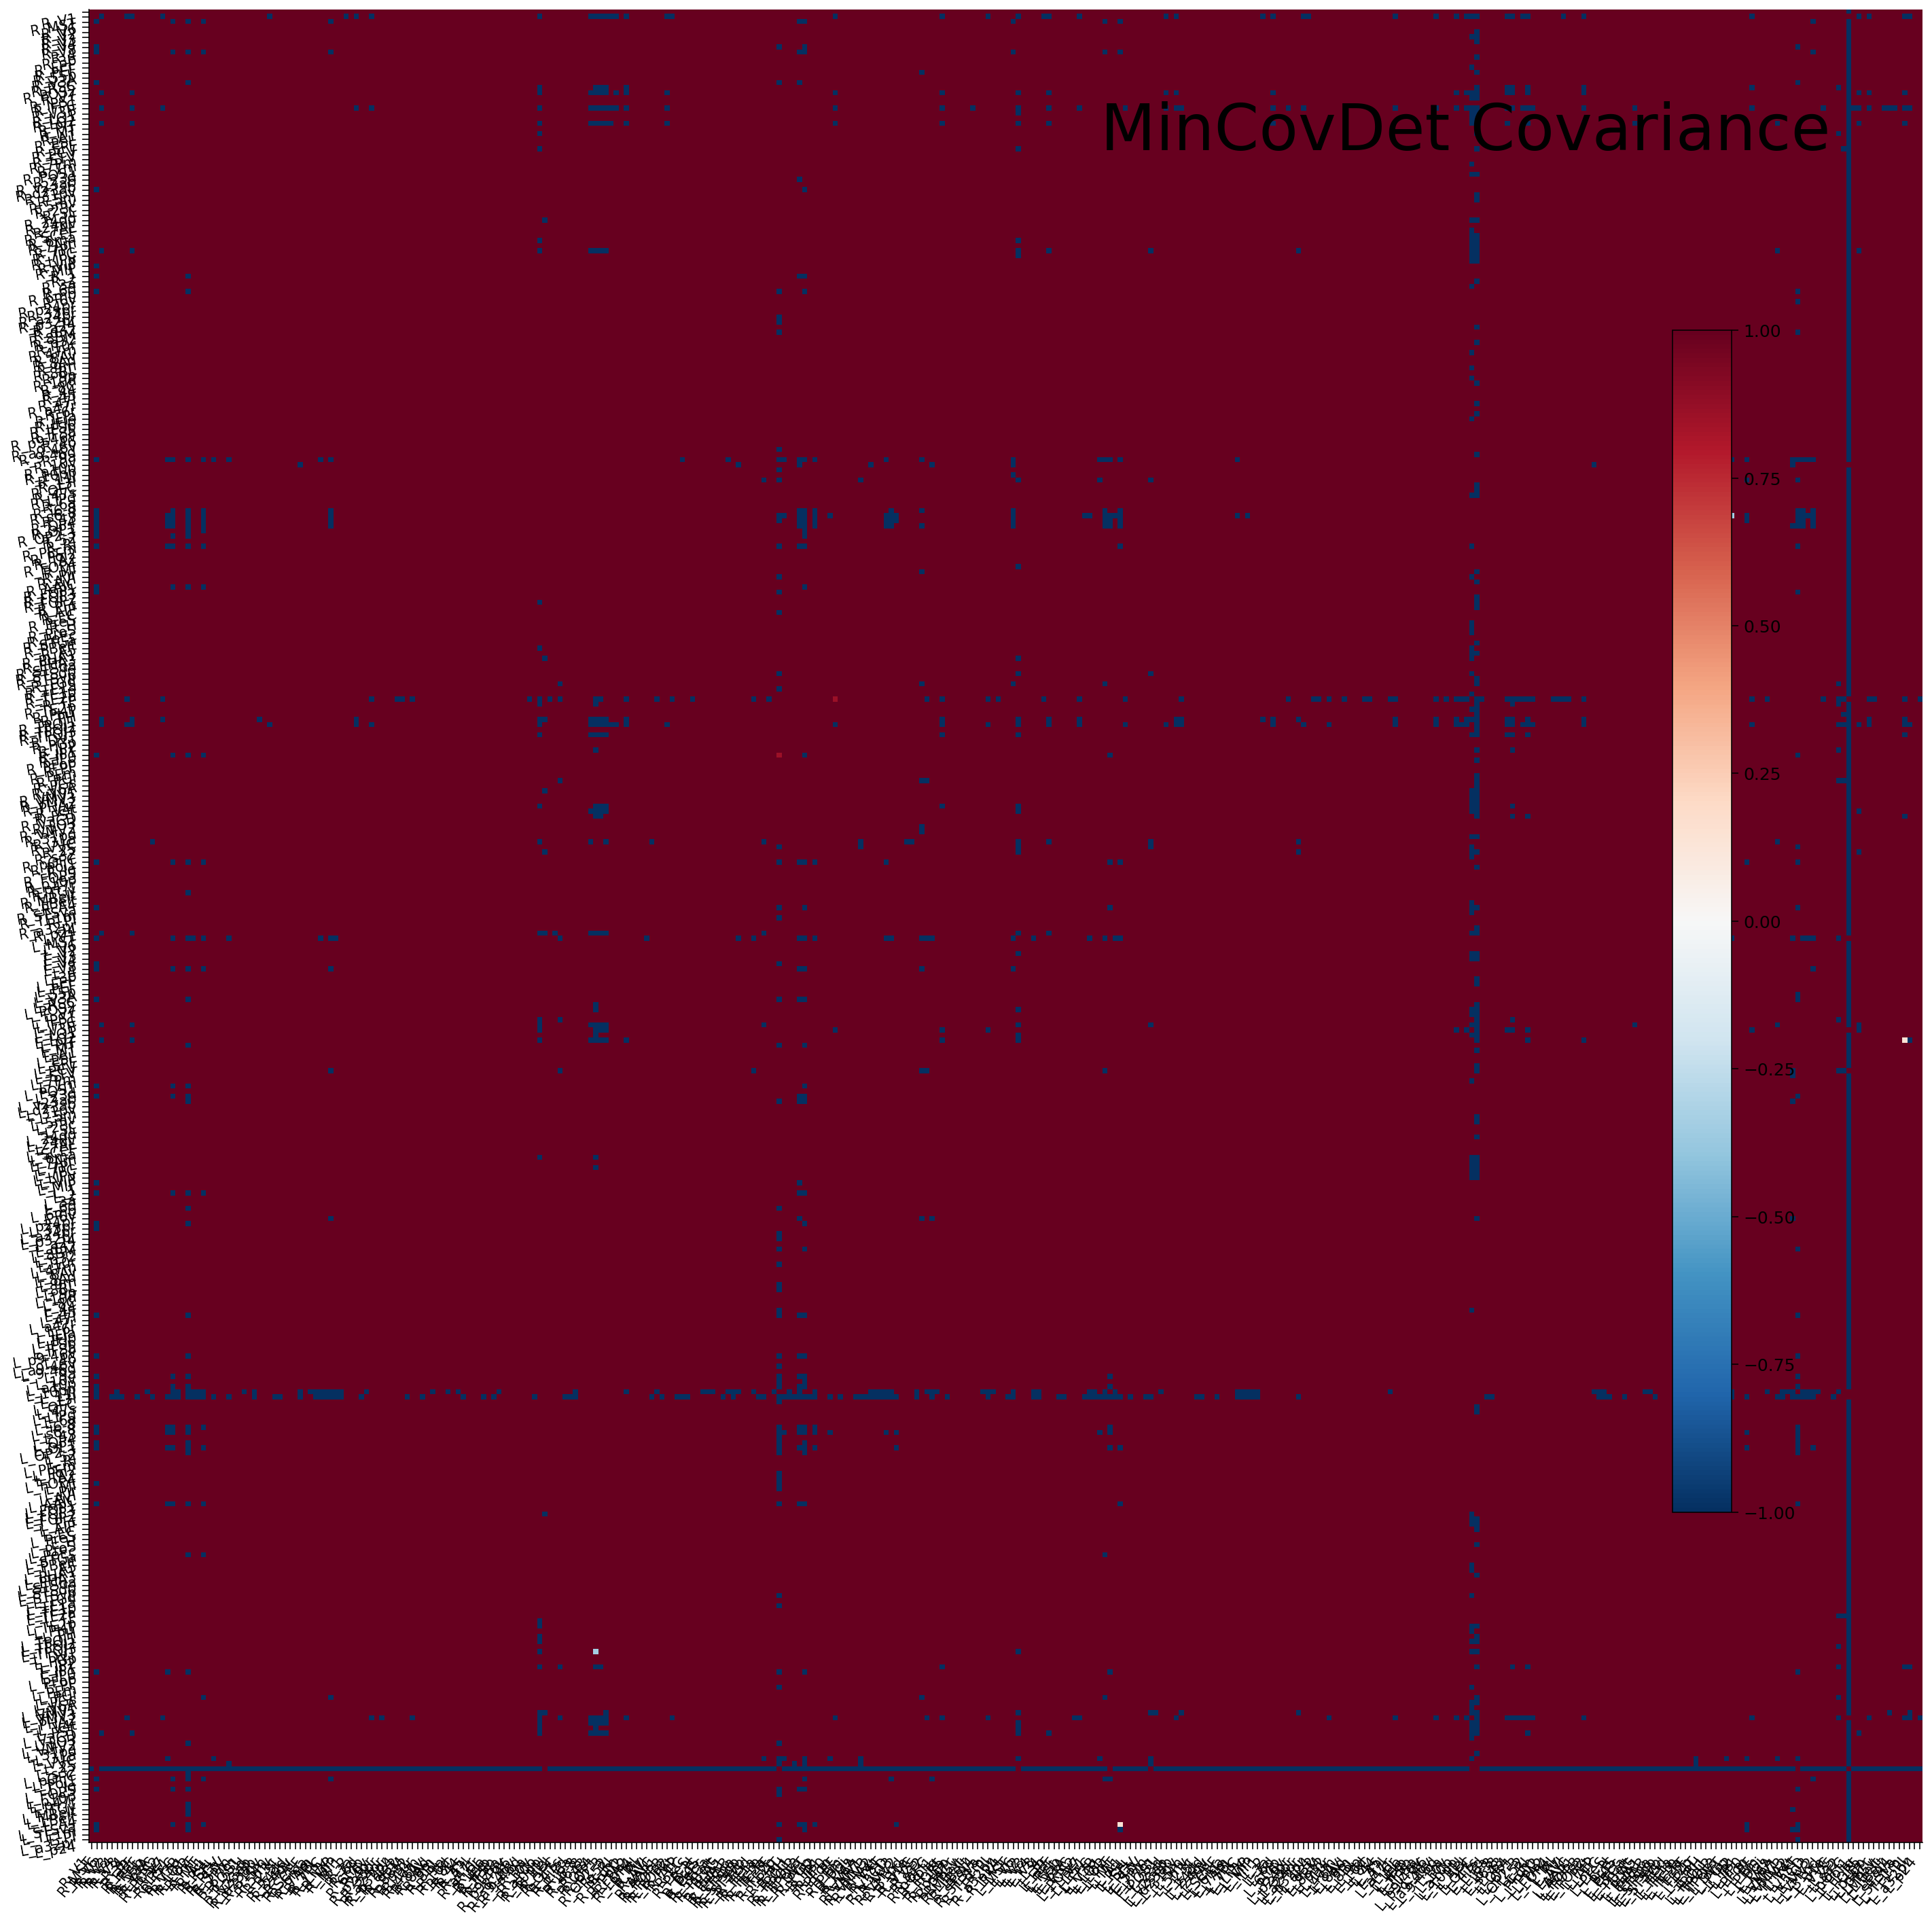

In [36]:
# The covariance can be found at estimator.covariance_
plotting.plot_matrix(estimator_mcd.covariance_, labels=region_name_list,
                     figure=(20, 20), vmax=1, vmin=-1,
                     title='MinCovDet Covariance')

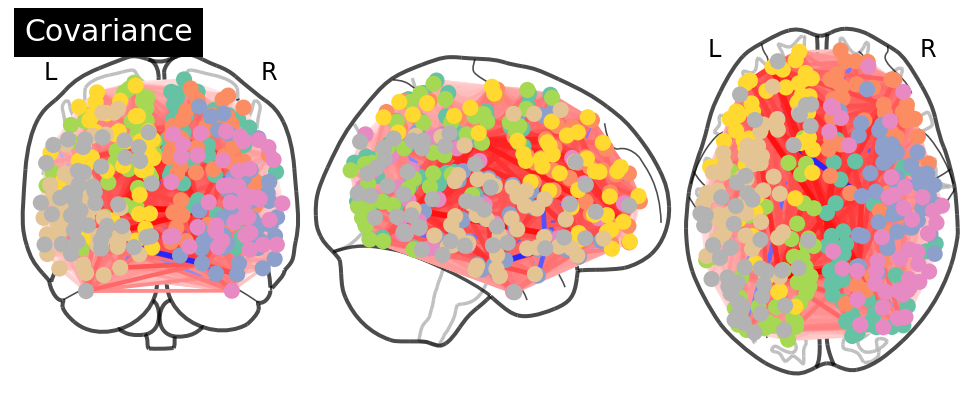

In [37]:
plotting.plot_connectome(estimator_mcd.covariance_, coords,
                         title='Covariance')

In [38]:
view = plotting.view_connectome(estimator_glc.covariance_, coords)
view.open_in_browser()

In [39]:
view = plotting.view_connectome(estimator_mcd.covariance_, coords)
view.open_in_browser()

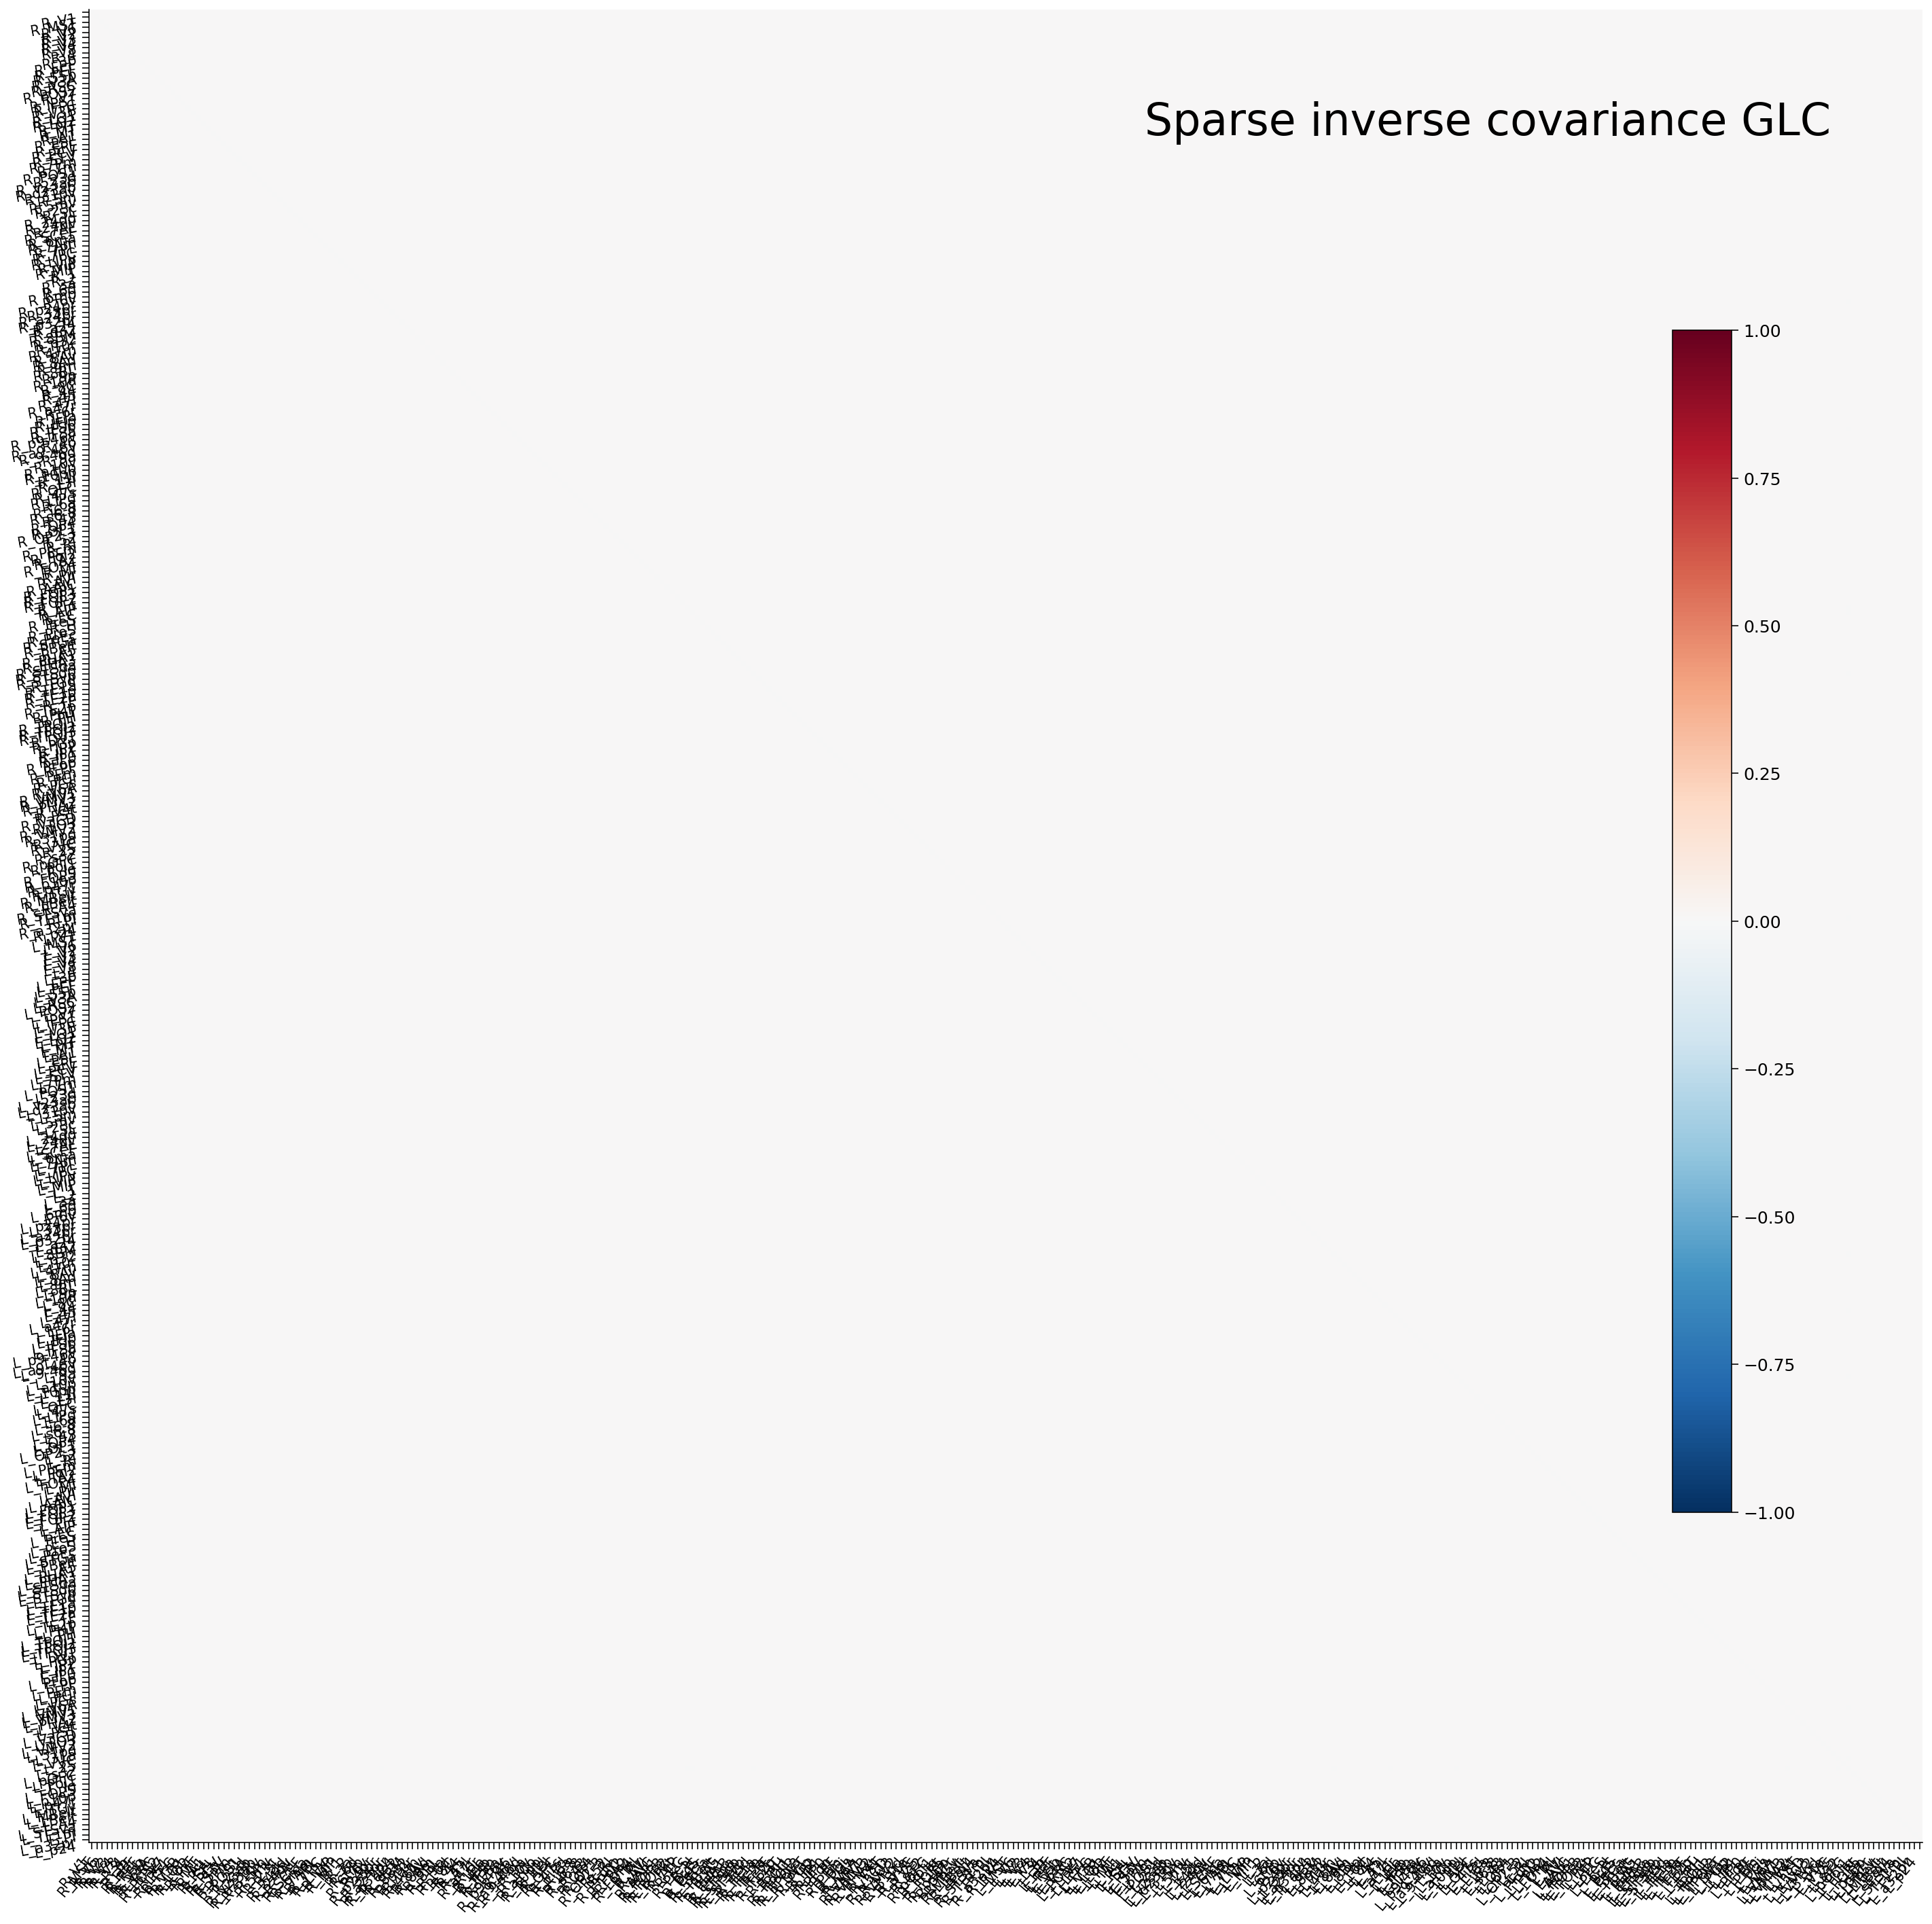

In [40]:
plotting.plot_matrix(-estimator_glc.precision_, labels=region_name_list,
                     figure=(20, 20), vmax=1, vmin=-1,
                     title='Sparse inverse covariance GLC')

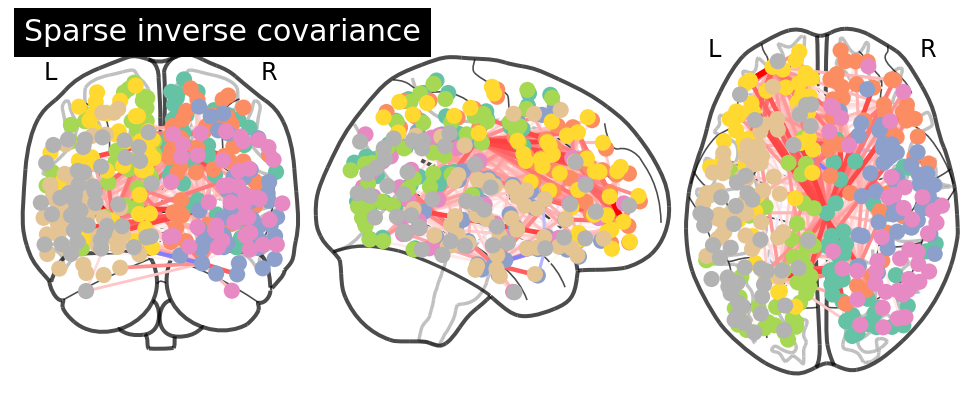

In [41]:
plotting.plot_connectome(-estimator_glc.precision_, coords,
                         title='Sparse inverse covariance')

plotting.show()

In [42]:
view = plotting.view_connectome(-estimator_glc.precision_, coords)

# In a Jupyter notebook, if ``view`` is the output of a cell, it will
# be displayed below the cell
view.open_in_browser()